# Boussinesq equation

$$ u_{tt} - u_{xx} - \varepsilon\frac{\beta}{2E} (u^2)_{xx} + \delta^2[d_1 u_{tttt} + d_2 u_{xxtt} + d_3 u_{xxxx}] = 0 $$

In [1]:
import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
from log_progress import log_progress

Domain and initial condition function:

Beta:             -27.642924800000003
Length parameter:  0.01
Linear velocity:   1.0
Soliton velocity:  1.0


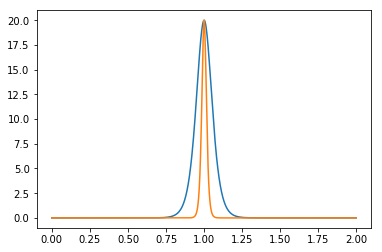

In [214]:
# domain
t0, tf = 0, 5
dt = (tf - t0)/50
T = np.linspace(t0, tf, int((tf - t0)/dt + 1))
pN = 1000
xl, xr = 0, 2
X = np.linspace(xl, xr, pN, endpoint=False)

# high frequency range for de-aliasing
hfreq1 = int(np.round(pN/3)) - 1
hfreq2 = int(np.round(2*pN/3)) + 1
da = np.ones_like(X)
da[hfreq1:hfreq2] = 0

# nonlinear and dispersive small parameters
rad = 0.01; slen = 0.1;
delta = np.sqrt(eps)
eps = 1e-4
#delta = 1
#eps = 1

# elastic moduli
rho = 1.06; E = 3.7; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PS

# nonlinearity and dispersion coefficients
beta = 3*E + 2*l*(1 - 2*nu)**3 + 4*m*(1 + nu)**2*(1 - 2*nu) + 6*n*nu**2
d1 = (1 + nu)/4; d2 = -(1 + nu + nu**2)/2; d3 = d1
#d1 = 0; d2 = -nu**2/3; d3 = 0

# amplitude 
#A = -1.0 # compression wave
#A = 0.15 # stretch wave

# localised wave
def f(x):
    #return (1 + np.sin(x))**2
    #return np.sin(x)
    return np.cos(2*x)**2 * ((x>7*L/16) & (x<9*L/16))

# soliton solution of the equation
def soliton(x, t):
    A = -20
    D = delta*np.sqrt(-4*(d1*(A*beta*eps + 3*E)**2 + 3*E*(A*beta*eps + 3*E)*d2 + 9*E**2*d3)
                  /(3*A*eps*beta*E))
    V = np.sqrt(1 + eps*A*beta/3/E)
    # shifted argument
    arg = ((x - V*t)%(xr - xl) - 1.0)/D
    #arg = ((x - V*t) - 3.0)/D
    # soliton and it's time derivatives
    u = A*np.cosh(arg)**(-2)
    v = 2*V/D*np.tanh(arg)*u
    w = 2*A*V**2/D**2*(-2 + np.cosh(2*arg))*np.cosh(arg)**(-4)
    q = 4*A*V**3/D**3*(-5 + np.cosh(2*arg))*np.cosh(arg)**(-4)*np.tanh(arg)
    return [u, v, w, q]

print("Beta:            ", beta)
print("Length parameter: ", D)
print("Linear velocity:  ", 1.0)
print("Soliton velocity: ", V)

def iv(x, t):
    #u = np.cosh((x - V*t)/lenp)**(-2)
    D = (xr - xl)/100
    #A = -1/2/D
    A = -20
    V = 1.0
    arg = ((x - V*t)%(xr - xl) - 1.0)/D
    #arg = ((x - V*t) - 3.0)/D
    # soliton and it's time derivatives
    u = A*np.cosh(arg)**(-2)
    v = 2*V/D*np.tanh(arg)*u
    w = 2*A*V**2/D**2*(-2 + np.cosh(2*arg))*np.cosh(arg)**(-4)
    q = 4*A*V**3/D**3*(-5 + np.cosh(2*arg))*np.cosh(arg)**(-4)*np.tanh(arg)
    return [u, v, w, q]

plt.plot(X, np.abs(soliton(X, 0)[0]), X, np.abs(iv(X, 0)[0]))
plt.show()

Derivative function

In [192]:
#frequencies
xi = np.fft.fftfreq(len(X))*(len(X))*2*np.pi /(X[-1] - X[0])
# when d1 = 0
def der2(t, y):
    u, v = y.reshape(2, -1)
    u2 = np.fft.fft(np.fft.ifft(u)**2)
    du = v
    dv = -xi**2*(u + eps*beta/2/E*u2 + delta**2*d3*xi**2*u) / (1 - delta**2*d2*xi**2)
    return np.concatenate((du, dv))

# three dispersive terms
def der4(t, y):
    u, v, w, q = y.reshape(4, -1)
    u2 = np.fft.fft(np.fft.ifft(u)**2)
    du, dv, dw = v, w, q
    dq = -(w + xi**2*(u + eps*beta/2/E*u2 - d2*delta**2*w + d3*delta**2*xi**2*u))/d1/delta**2
    return np.concatenate((du, dv, dw, dq))

Solve and plot

In [207]:
# de-aliased initial conditions
sol = soliton(X, 0)
u0 = np.fft.fft(sol[0])*da; v0 = np.fft.fft(sol[1])*da
w0 = np.fft.fft(sol[2])*da; q0 = np.fft.fft(sol[3])*da
#u0 = np.fft.fft(f(X))
#v0 = -1.j*xi*u0; w0 = -1.j*xi*v0; q0 = -1.j*xi*w0
#v0 = np.zeros_like(u0, dtype='complex')
#w0 = np.zeros_like(u0, dtype='complex')
#q0 = np.zeros_like(u0, dtype='complex')

# difference between soliton and numerical solution
def error(t, u):
    return max(abs(soliton(X, t)[0] - u))

U = [sol[0],]; T_saved = [t0,] # containers for solution and time
err = [0.0,]
uk = np.concatenate((u0, v0, w0, q0))
ok = True # every loop iteration one iteration of RK is done

for i in log_progress(range(1, len(T)), every=1):
    sln = sp.integrate.solve_ivp(der4, (0, dt), uk, method='RK45')
    # extract solution
    u, v, w, q = sln.y[:, -1].reshape(4, -1)
    # dealiasing
    u *= da; v *= da; w *= da; q *= da
    # save solution at each n-th time-point
    if not i%1:
        U.append(np.fft.ifft(u).real)
        T_saved.append(T[i])
        #err.append(error(T[i], U[-1]))
    # define next initial condition for integrator
    uk = np.concatenate((u, v, w, q))
    
#print('Last error: ', err[-1])

In [208]:
fig, axes = plt.subplots(figsize=(8, 4))
plt.title('Soluton animation')
plt.xlim(X[0], X[-1]) 
plt.ylim(-0.5*np.abs(A), 1.2*np.abs(A))
line1, = axes.plot([], [], lw=2)
line2, = axes.plot([], [], lw=2)
time_template = 'time = %.1f'
time_text = axes.text(0.8, 0.9, '', transform=axes.transAxes)
plt.minorticks_on()
plt.close()
dx = (X[-1] - X[0]) / pN

def plot_frame(i):
    axes.set_xlim(X[0], X[-1])
    #r = -int(np.round((V*T_saved[i] - X[0])/dx))
    line1.set_data(X, -U[i])
    #line2.set_data(X + V*T_saved[i], np.roll(np.abs(soliton(X, T_saved[i])[0]), r))
    #line2.set_data(X + V*T_saved[i], np.abs(soliton(X, 0)[0]))
    time_text.set_text(time_template % T_saved[i])
    fig.canvas.draw()
    return fig

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(U), interval=100, repeat=False)